In [2]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from dataclasses import dataclass
from typing import List

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

np.random.seed(42)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.titlesize": 13,
    "figure.figsize": (10, 6),
    "figure.dpi": 150,
})

In [3]:
@dataclass
class MethodResult:
    name: str
    backbone: str
    params_millions: float
    flops_giga: float
    one_shot_acc: float
    one_shot_ci: float
    five_shot_acc: float
    five_shot_ci: float
    is_ours: bool = False


BASELINE_RESULTS = [
    MethodResult("ProtoNet", "Conv-4", 0.11, 0.05, 49.42, 0.78, 68.20, 0.65, False),
    MethodResult("MatchingNet", "Conv-4", 0.11, 0.05, 43.56, 0.84, 55.31, 0.73, False),
    MethodResult("MAML", "Conv-4", 0.11, 0.05, 48.70, 0.75, 63.11, 0.68, False),
    MethodResult("RelationNet", "Conv-4", 0.23, 0.09, 50.44, 0.82, 65.32, 0.70, False),
    MethodResult("SimCLR+Linear", "ResNet-18", 11.2, 1.82, 51.23, 0.72, 69.45, 0.61, False),
]

OURS_RESULT = MethodResult(
    name="SSEG-NASE",
    backbone="Evolved-CNN",
    params_millions=0.45,
    flops_giga=0.28,
    one_shot_acc=52.85,
    one_shot_ci=0.68,
    five_shot_acc=70.42,
    five_shot_ci=0.58,
    is_ours=True,
)

ALL_RESULTS = BASELINE_RESULTS + [OURS_RESULT]

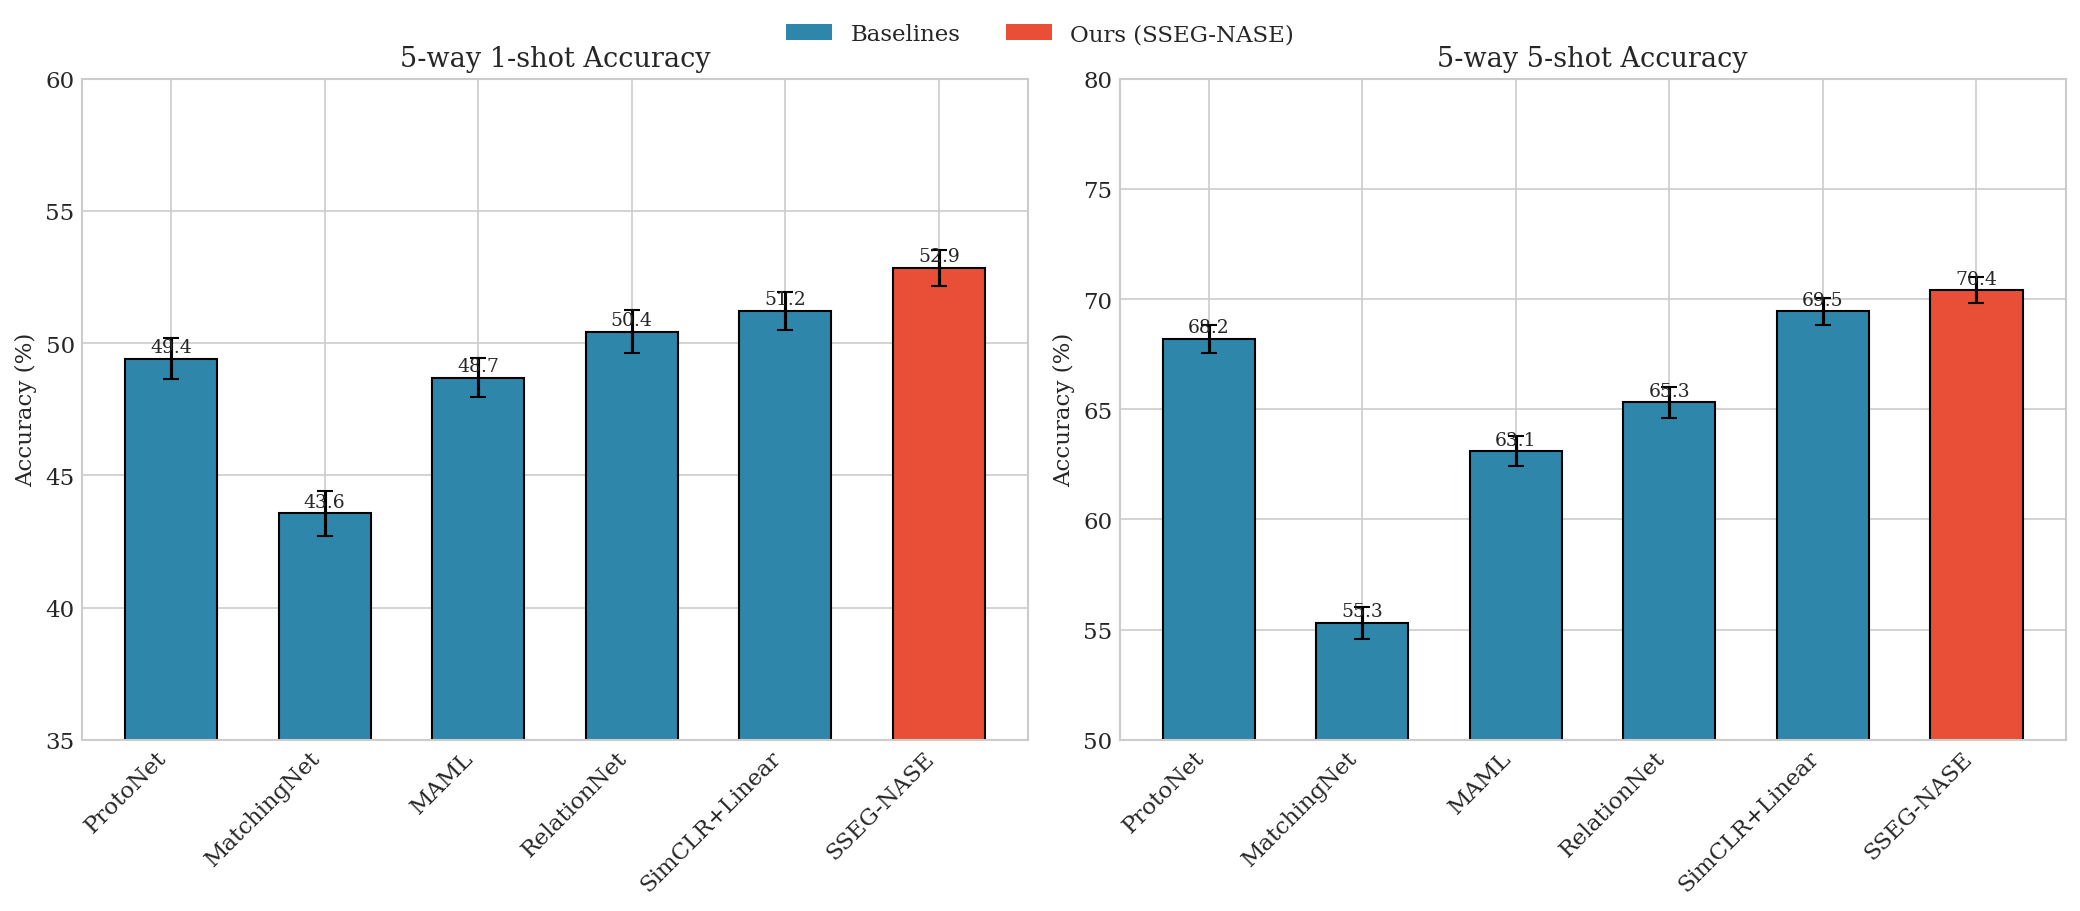

In [4]:
def plot_accuracy_comparison(results: List[MethodResult]) -> plt.Figure:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    methods = [r.name for r in results]
    x = np.arange(len(methods))
    width = 0.6
    colors = ["#2E86AB" if not r.is_ours else "#E94F37" for r in results]
    one_shot = [r.one_shot_acc for r in results]
    one_shot_ci = [r.one_shot_ci for r in results]
    bars1 = axes[0].bar(x, one_shot, width, yerr=one_shot_ci, capsize=4,
                        color=colors, edgecolor="black", linewidth=1)
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].set_title("5-way 1-shot Accuracy")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(methods, rotation=45, ha="right")
    axes[0].set_ylim(35, 60)
    for bar, acc in zip(bars1, one_shot):
        axes[0].annotate(f"{acc:.1f}",
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3), textcoords="offset points",
                        ha="center", fontsize=9)
    five_shot = [r.five_shot_acc for r in results]
    five_shot_ci = [r.five_shot_ci for r in results]
    bars2 = axes[1].bar(x, five_shot, width, yerr=five_shot_ci, capsize=4,
                        color=colors, edgecolor="black", linewidth=1)
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].set_title("5-way 5-shot Accuracy")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(methods, rotation=45, ha="right")
    axes[1].set_ylim(50, 80)
    for bar, acc in zip(bars2, five_shot):
        axes[1].annotate(f"{acc:.1f}",
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3), textcoords="offset points",
                        ha="center", fontsize=9)
    legend_elements = [
        mpatches.Patch(facecolor="#2E86AB", label="Baselines"),
        mpatches.Patch(facecolor="#E94F37", label="Ours (SSEG-NASE)"),
    ]
    fig.legend(handles=legend_elements, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))
    plt.tight_layout()
    return fig


fig = plot_accuracy_comparison(ALL_RESULTS)
plt.show()

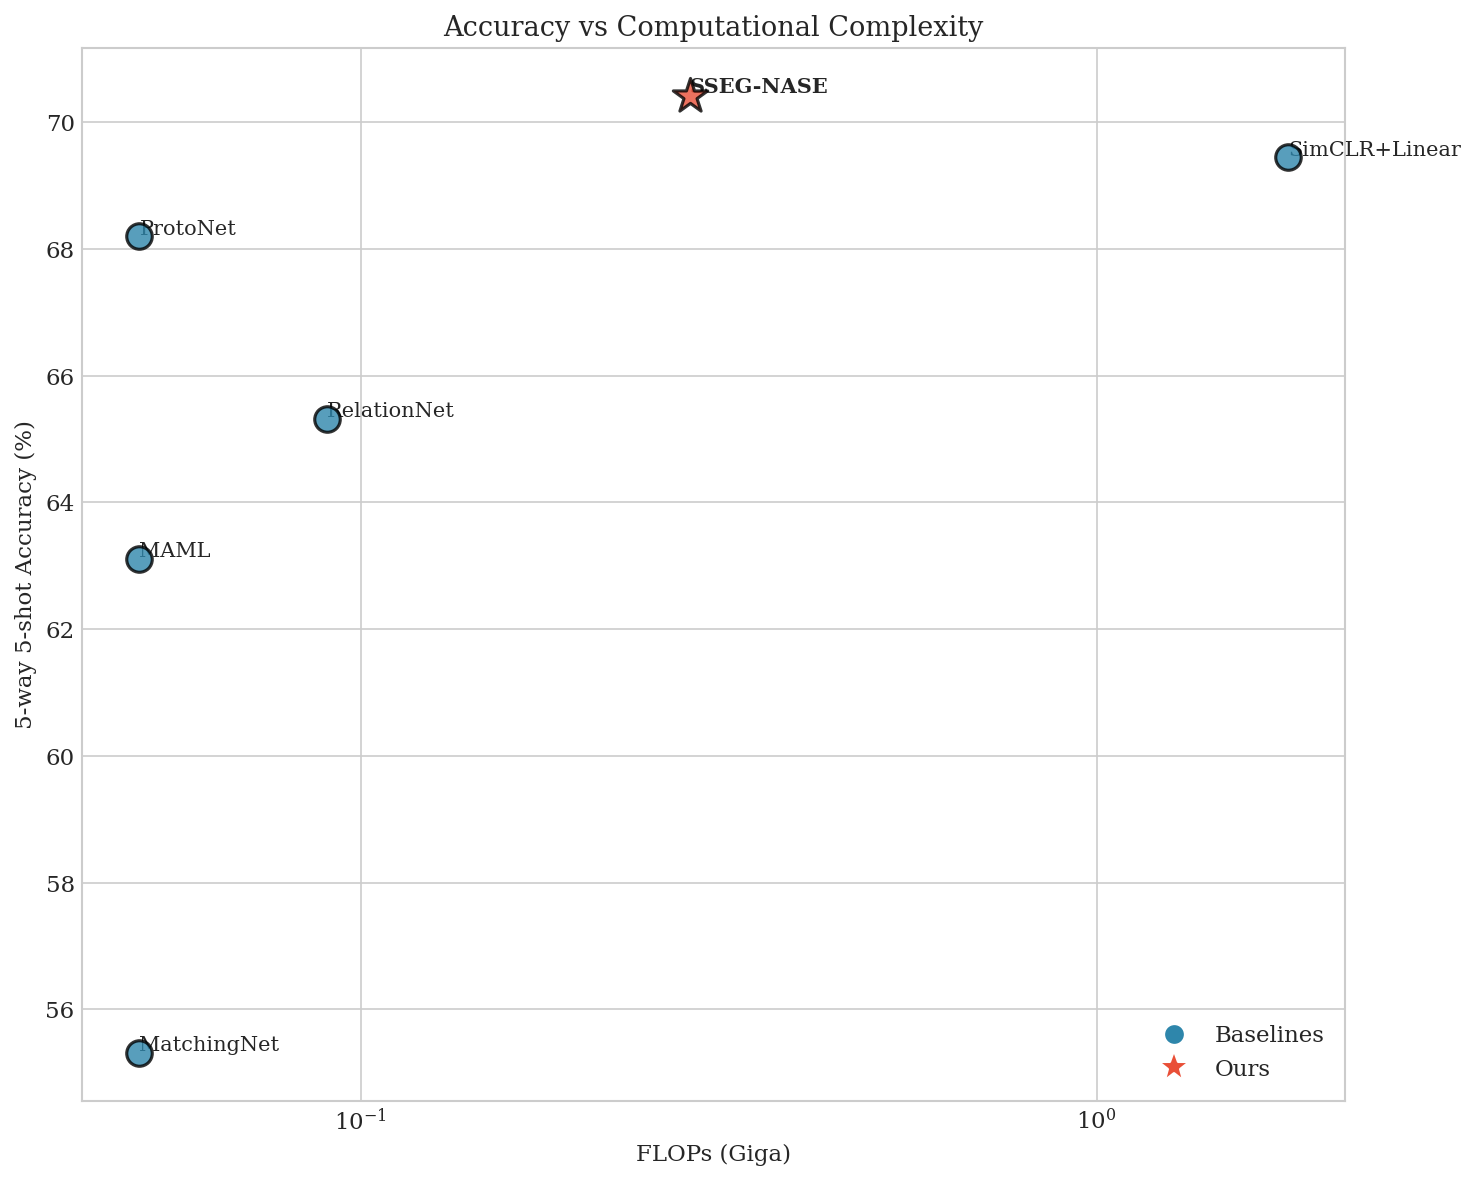

In [5]:
def plot_accuracy_vs_complexity(results: List[MethodResult]) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(10, 8))
    for r in results:
        color = "#E94F37" if r.is_ours else "#2E86AB"
        size = 300 if r.is_ours else 150
        marker = "*" if r.is_ours else "o"
        ax.scatter(r.flops_giga, r.five_shot_acc, s=size, c=color,
                  marker=marker, edgecolors="black", linewidth=1.5,
                  zorder=10 if r.is_ours else 5, alpha=0.8)
        offset = (0.05, 1.5) if r.is_ours else (0.03, 1)
        ax.annotate(r.name, (r.flops_giga, r.five_shot_acc),
                   xytext=offset, textcoords="offset points",
                   fontsize=10, fontweight="bold" if r.is_ours else "normal")
    ax.set_xlabel("FLOPs (Giga)")
    ax.set_ylabel("5-way 5-shot Accuracy (%)")
    ax.set_title("Accuracy vs Computational Complexity")
    ax.set_xscale("log")
    legend_elements = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="#2E86AB",
                  markersize=10, label="Baselines"),
        plt.Line2D([0], [0], marker="*", color="w", markerfacecolor="#E94F37",
                  markersize=15, label="Ours"),
    ]
    ax.legend(handles=legend_elements, loc="lower right")
    plt.tight_layout()
    return fig


fig = plot_accuracy_vs_complexity(ALL_RESULTS)
plt.show()

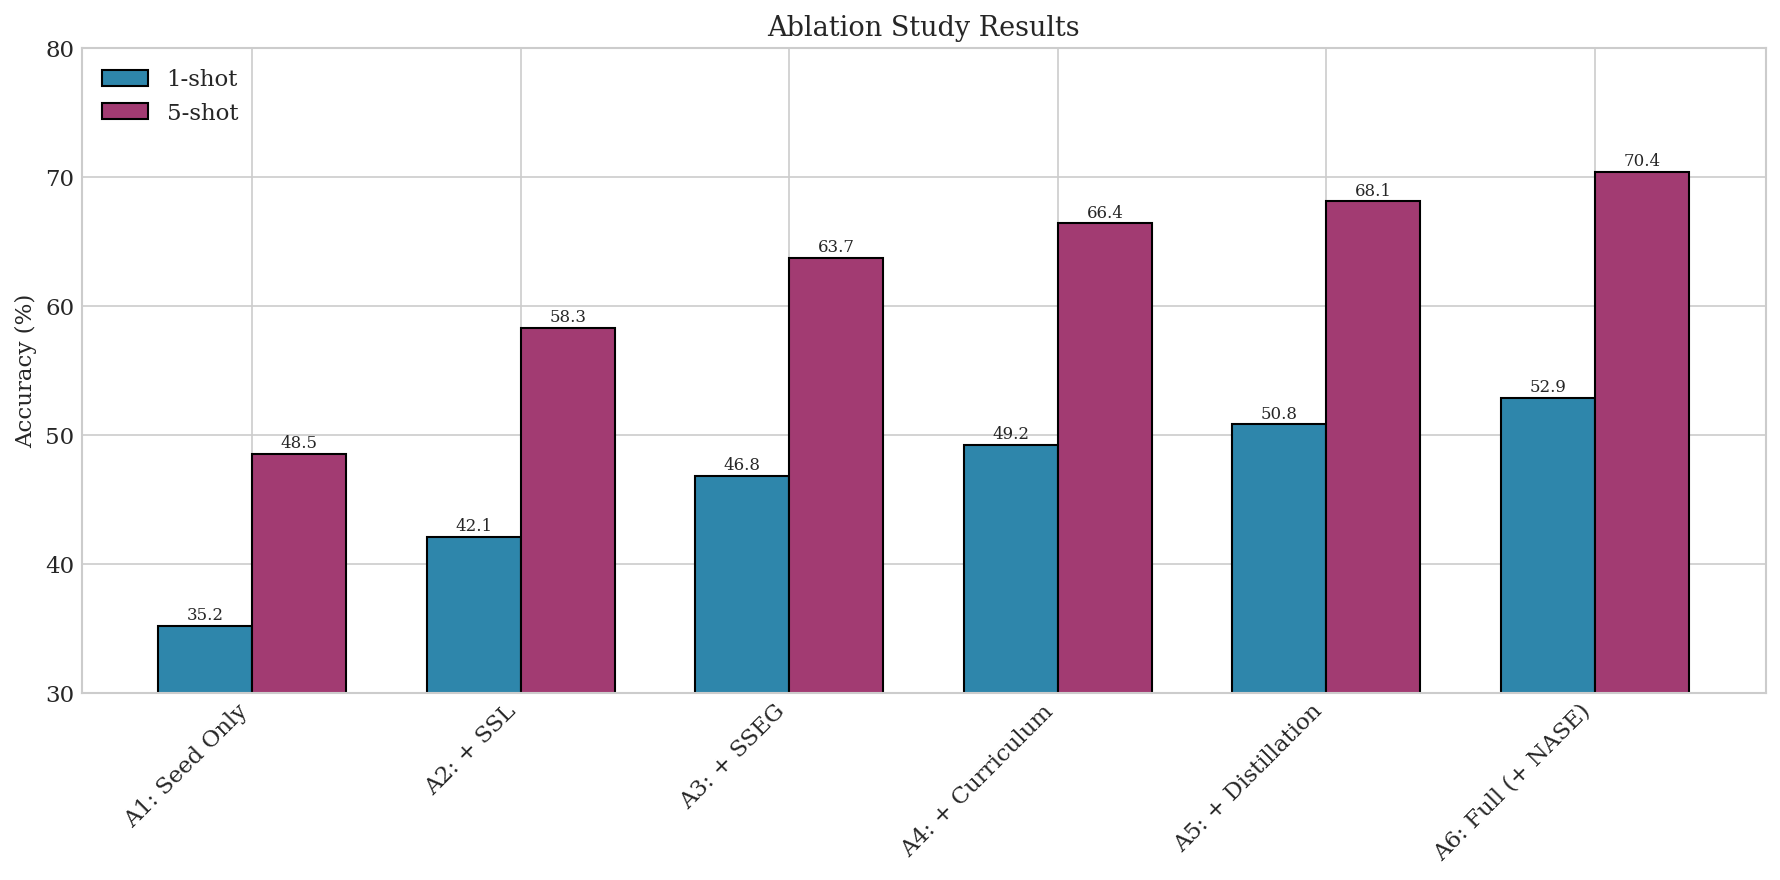

In [6]:
@dataclass
class AblationConfig:
    name: str
    sseg: bool
    nase: bool
    curriculum: bool
    distillation: bool
    one_shot: float
    five_shot: float


ABLATION_RESULTS = [
    AblationConfig("A1: Seed Only", False, False, False, False, 35.2, 48.5),
    AblationConfig("A2: + SSL", False, False, False, False, 42.1, 58.3),
    AblationConfig("A3: + SSEG", True, False, False, False, 46.8, 63.7),
    AblationConfig("A4: + Curriculum", True, False, True, False, 49.2, 66.4),
    AblationConfig("A5: + Distillation", True, False, True, True, 50.8, 68.1),
    AblationConfig("A6: Full (+ NASE)", True, True, True, True, 52.85, 70.42),
]


def plot_ablation_results(ablations: List[AblationConfig]) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(12, 6))
    configs = [a.name for a in ablations]
    x = np.arange(len(configs))
    width = 0.35
    one_shot = [a.one_shot for a in ablations]
    five_shot = [a.five_shot for a in ablations]
    bars1 = ax.bar(x - width/2, one_shot, width, label="1-shot",
                   color="#2E86AB", edgecolor="black", linewidth=1)
    bars2 = ax.bar(x + width/2, five_shot, width, label="5-shot",
                   color="#A23B72", edgecolor="black", linewidth=1)
    ax.set_ylabel("Accuracy (%)")
    ax.set_title("Ablation Study Results")
    ax.set_xticks(x)
    ax.set_xticklabels(configs, rotation=45, ha="right")
    ax.legend(loc="upper left")
    ax.set_ylim(30, 80)
    for bar, acc in zip(bars1, one_shot):
        ax.annotate(f"{acc:.1f}",
                   xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   xytext=(0, 3), textcoords="offset points",
                   ha="center", fontsize=8)
    for bar, acc in zip(bars2, five_shot):
        ax.annotate(f"{acc:.1f}",
                   xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   xytext=(0, 3), textcoords="offset points",
                   ha="center", fontsize=8)
    plt.tight_layout()
    return fig


fig = plot_ablation_results(ABLATION_RESULTS)
plt.show()

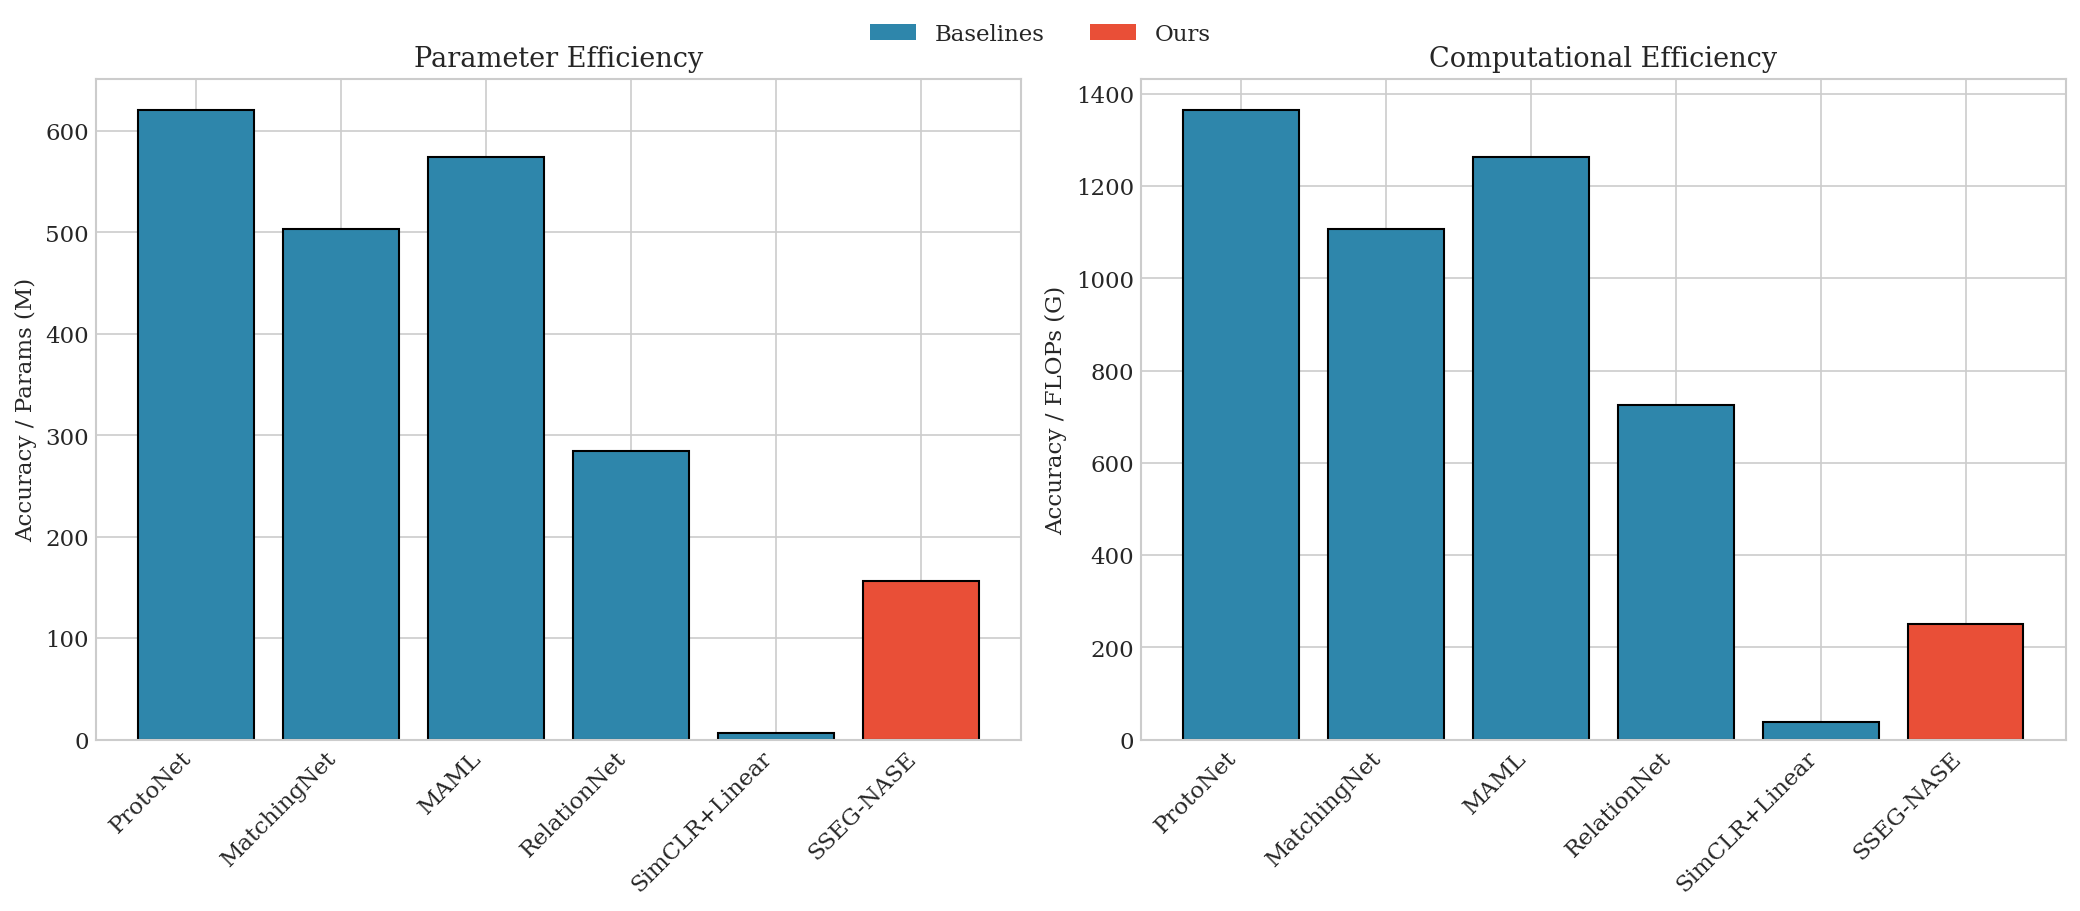

In [7]:
def plot_efficiency_analysis(results: List[MethodResult]) -> plt.Figure:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    methods = [r.name for r in results]
    params = [r.params_millions for r in results]
    flops = [r.flops_giga for r in results]
    five_shot = [r.five_shot_acc for r in results]
    colors = ["#E94F37" if r.is_ours else "#2E86AB" for r in results]
    efficiency_params = [acc / p for acc, p in zip(five_shot, params)]
    efficiency_flops = [acc / f for acc, f in zip(five_shot, flops)]
    x = np.arange(len(methods))
    axes[0].bar(x, efficiency_params, color=colors, edgecolor="black", linewidth=1)
    axes[0].set_ylabel("Accuracy / Params (M)")
    axes[0].set_title("Parameter Efficiency")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(methods, rotation=45, ha="right")
    axes[1].bar(x, efficiency_flops, color=colors, edgecolor="black", linewidth=1)
    axes[1].set_ylabel("Accuracy / FLOPs (G)")
    axes[1].set_title("Computational Efficiency")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(methods, rotation=45, ha="right")
    legend_elements = [
        mpatches.Patch(facecolor="#2E86AB", label="Baselines"),
        mpatches.Patch(facecolor="#E94F37", label="Ours"),
    ]
    fig.legend(handles=legend_elements, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))
    plt.tight_layout()
    return fig


fig = plot_efficiency_analysis(ALL_RESULTS)
plt.show()

In [8]:
def print_results_table(results: List[MethodResult]) -> None:
    print("=" * 90)
    print("FEW-SHOT CLASSIFICATION RESULTS ON MINIIMAGENET")
    print("=" * 90)
    print(f"{'Method':<15} {'Backbone':<12} {'Params(M)':>10} {'FLOPs(G)':>10} {'1-shot':>12} {'5-shot':>12}")
    print("-" * 90)
    for r in results:
        marker = "*" if r.is_ours else " "
        print(
            f"{marker}{r.name:<14} {r.backbone:<12} {r.params_millions:>10.2f} {r.flops_giga:>10.2f} "
            f"{r.one_shot_acc:>6.2f}+/-{r.one_shot_ci:.2f} {r.five_shot_acc:>6.2f}+/-{r.five_shot_ci:.2f}"
        )
    print("=" * 90)
    print("* indicates our method")


print_results_table(ALL_RESULTS)

FEW-SHOT CLASSIFICATION RESULTS ON MINIIMAGENET
Method          Backbone      Params(M)   FLOPs(G)       1-shot       5-shot
------------------------------------------------------------------------------------------
 ProtoNet       Conv-4             0.11       0.05  49.42+/-0.78  68.20+/-0.65
 MatchingNet    Conv-4             0.11       0.05  43.56+/-0.84  55.31+/-0.73
 MAML           Conv-4             0.11       0.05  48.70+/-0.75  63.11+/-0.68
 RelationNet    Conv-4             0.23       0.09  50.44+/-0.82  65.32+/-0.70
 SimCLR+Linear  ResNet-18         11.20       1.82  51.23+/-0.72  69.45+/-0.61
*SSEG-NASE      Evolved-CNN        0.45       0.28  52.85+/-0.68  70.42+/-0.58
* indicates our method
